## Avaliação em holdouts - Palco 2010

Palco 2010 presents no interactions in months 6, 7, 8 and 9.  
Consequently, the third quarter presents almost no interactions.  
Moreover, first and last quarters contain most interactions.  
When divided by two semesters, the first semester presents almost twice the interactions of the second.  

109 users of 7580 (1.438%) occurr in 80.0% or more months.  
0 users of 7580 (0.0%) occurr in 80.0% or more quarters.  
1102 users of 7580 (14.538%) occurr in 80.0% or more semesters.  
___ 

When divided in buckets of same size, number of users per bucket is between 1k and 2k.  
147 users of 7580 (1.939%) occur in 80.0% or more buckets.  
There are at least 100 frequent users in each bucket. Their number of interactions reduces with time.  
Buckets present interactions from at most 2 months, with the exception of bucket 9, which presents interactions from months 5, 10, and 11.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
## Read Data

In [4]:
# importa dataset 'palco playlists'
data = pd.read_csv('output/palco_2010_dump/sampled_palco2010.csv')
user_col = 'user_id'
item_col = 'track_id'

In [5]:
data.shape, data.user_id.nunique(), data.track_id.nunique()

((435621, 7), 2921, 22103)

In [6]:
data[['user_id', 'track_id']].duplicated().sum()

210466

In [7]:
data.shape

(435621, 7)

In [8]:
data.head()

,user_id,track_id,timestamp,date2,year,month,date
0,4220,31313,2010-01-01 00:10:36,2010-01-01,2010,1,2010-01-01
1,4220,29567,2010-01-01 00:13:07,2010-01-01,2010,1,2010-01-01
2,4220,31313,2010-01-01 00:13:18,2010-01-01,2010,1,2010-01-01
3,6258,18106,2010-01-01 00:46:25,2010-01-01,2010,1,2010-01-01
4,42186,5066,2010-01-01 00:50:59,2010-01-01,2010,1,2010-01-01


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435621 entries, 0 to 435620
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    435621 non-null  int64 
 1   track_id   435621 non-null  int64 
 2   timestamp  435621 non-null  object
 3   date2      435621 non-null  object
 4   year       435621 non-null  int64 
 5   month      435621 non-null  int64 
 6   date       435621 non-null  object
dtypes: int64(4), object(3)
memory usage: 23.3+ MB


### Convert timestamp

In [10]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: total: 3.28 s
Wall time: 4.83 s


In [12]:
data.head()

,user_id,track_id,timestamp,date2,year,month,date
0,4220,31313,2010-01-01 00:10:36,2010-01-01,2010,1,2010-01-01
1,4220,29567,2010-01-01 00:13:07,2010-01-01,2010,1,2010-01-01
2,4220,31313,2010-01-01 00:13:18,2010-01-01,2010,1,2010-01-01
3,6258,18106,2010-01-01 00:46:25,2010-01-01,2010,1,2010-01-01
4,42186,5066,2010-01-01 00:50:59,2010-01-01,2010,1,2010-01-01


CPU times: total: 15.6 ms
Wall time: 168 ms


Text(0.5, 1.0, 'interactions per month')

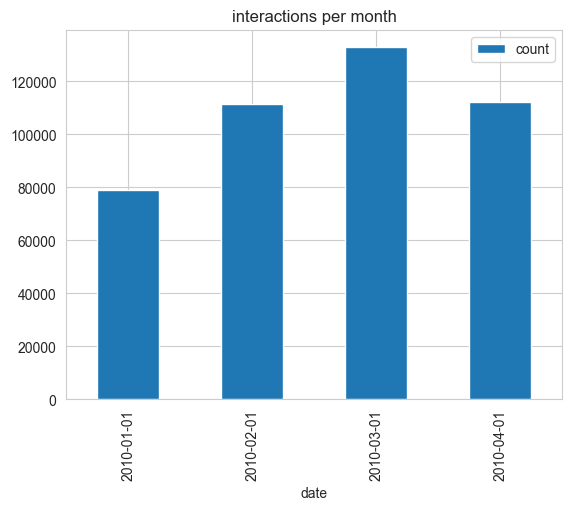

In [13]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month')

___
## Get intervals and Frequent users (threshold = 0.75)

time intervals

In [14]:
# user_presence_df = pd.read_csv('output/amazon_digmusic_dump/sample_user_presence_df.csv')
# user_month_interactions = pd.read_csv('output/amazon_digmusic_dump/sample_user_month_interactions.csv')
# frequent_users_month = joblib.load('output/amazon_digmusic_dump/sample_frequent_users_month.joblib')

___
## Experiments using months

In [14]:
data.shape

(435621, 7)

In [15]:
%%time
# 1min 29s
buckets, holdouts = getBucketsHoldouts(
    data=data,# data[ data['date'].dt.month==1 ],# 
    user_col=user_col,
    item_col=item_col,
    frequent_users=data['user_id'].unique(),# frequent_users_month, # for every user in holdout: data['user_id'].unique()
    interval_type='M',
    intervals=None, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .


KeyboardInterrupt: 

In [ ]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

435621

In [ ]:
joblib.dump(buckets, 'output/palco_2010_dump/sample_buckets.joblib')
joblib.dump(holdouts, 'output/palco_2010_dump/sample_holdouts.joblib')

['output/palco_2010_dump/sample_holdouts.joblib']

In [16]:
buckets = joblib.load('output/palco_2010_dump/sample_buckets.joblib')
holdouts = joblib.load('output/palco_2010_dump/sample_holdouts.joblib')

In [17]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(78313, 1248, 9958),
 (110572, 1371, 12659),
 (131966, 1473, 12685),
 (111482, 1538, 13972)]

In [18]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(699, 699, 586), (768, 768, 666), (874, 874, 754), (947, 947, 813)]

### ISGD

In [22]:
%%time
import itertools
def grid_search(model, stream, random_seed = 10, interleaved=10):    
    num_factors = [50, 100, 150, 200]
    num_iter = [1, 2, 5, 8]
    learn_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
    regularization = [0.01, 0.05, 0.1, 0.25, 0.5]
    num_nodes = [1, 2, 4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
    grid = list(itertools.product(*grid))
    results = []
    for i, hp in enumerate(grid):
        print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg, nn = hp
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@N']) )
    return grid, results    

# OPTIONAL FOR NOW
prop = 0.1 # 0.05
hp_sample = data.iloc[:round( data.shape[0]*prop )]
stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    
grid, results = grid_search(model=ISGD, stream=stream, random_seed=10, interleaved=1 )
len(grid), len(results), max(results) # (243, 243, 0.0026656511805026656)

0.0 %
0.05 %
0.1 %
0.15 %
0.2 %
0.25 %
0.3 %
0.35 %
0.4 %
0.45 %
0.5 %
0.55 %
0.6 %
0.65 %
0.7 %
0.75 %
0.8 %
0.85 %
0.9 %
0.95 %
1.0 %
1.05 %
1.1 %
1.15 %
1.2 %
1.25 %
1.3 %
1.35 %
1.4 %
1.45 %
1.5 %
1.55 %
1.6 %
1.65 %
1.7 %
1.75 %
1.8 %
1.85 %
1.9 %
1.95 %
2.0 %
2.05 %
2.1 %
2.15 %
2.2 %
2.25 %
2.3 %
2.35 %
2.4 %
2.45 %
2.5 %
2.55 %
2.6 %
2.65 %
2.7 %
2.75 %
2.8 %
2.85 %
2.9 %
2.95 %
3.0 %
3.05 %
3.1 %
3.15 %
3.2 %
3.25 %
3.3 %
3.35 %
3.4 %
3.45 %
3.5 %
3.55 %
3.6 %
3.65 %
3.7 %
3.75 %


c:\Users\mjlav\Desktop\work\european_comission\measuring_forgetting\notebooks/..\recommenders_implicit\ISGD.py:119: RuntimeWarning: overflow encountered in multiply
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)
c:\Users\mjlav\Desktop\work\european_comission\measuring_forgetting\notebooks/..\recommenders_implicit\ISGD.py:119: RuntimeWarning: invalid value encountered in subtract
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)
c:\Users\mjlav\Desktop\work\european_comission\measuring_forgetting\notebooks/..\recommenders_implicit\ISGD.py:113: RuntimeWarning: invalid value encountered in add
  p_u += delta
c:\Users\mjlav\Desktop\work\european_comission\measuring_forgetting\notebooks/..\recommenders_implicit\ISGD.py:112: RuntimeWarning: overflow encountered in multiply
  delta = self.learn_rate * (err * q_i - self.user_regularization * p_u)


3.8 %
3.85 %
3.9 %
3.95 %
4.0 %
4.05 %
4.1 %
4.15 %
4.2 %
4.25 %
4.3 %
4.35 %
4.4 %
4.45 %
4.5 %
4.55 %
4.6 %
4.65 %
4.7 %
4.75 %
4.8 %
4.85 %
4.9 %
4.95 %
5.0 %
5.05 %
5.1 %
5.15 %
5.2 %
5.25 %
5.3 %
5.35 %
5.4 %
5.45 %
5.5 %
5.55 %
5.6 %
5.65 %
5.7 %
5.75 %
5.8 %
5.85 %
5.9 %
5.95 %
6.0 %
6.05 %
6.1 %
6.15 %
6.2 %
6.25 %
6.3 %
6.35 %
6.4 %
6.45 %
6.5 %
6.55 %
6.6 %
6.65 %
6.7 %
6.75 %
6.8 %
6.85 %
6.9 %
6.95 %
7.0 %
7.05 %
7.1 %
7.15 %
7.2 %
7.25 %
7.3 %
7.35 %
7.4 %
7.45 %
7.5 %
7.55 %
7.6 %
7.65 %
7.7 %
7.75 %
7.8 %
7.85 %
7.9 %
7.95 %
8.0 %
8.05 %
8.1 %
8.15 %
8.2 %
8.25 %
8.3 %
8.35 %
8.4 %
8.45 %
8.5 %
8.55 %
8.6 %
8.65 %


In [ ]:
# num_factors, num_iter, learn_rate, regularization, num_nodes = grid[ np.argmax( results ) ]
grid[ np.argmax( results ) ] # meh just ignore this (150, 8, 0.5, 0.3, 4)

In [19]:
# define hyperparameters
num_factors = 200
num_iter = 6
learn_rate = 0.35
regularization = 0.5
num_nodes = 8

In [20]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [21]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [22]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 373
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 502
Test Holdout 3
recommendations not made for users in holdout 3 x checkpoint 0: 603
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 325
Test Holdout 3
recommendations not made for users in holdout 3 x checkpoint 1: 464
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
Test Holdout 3
recommendations not made for users in holdout 3 x checkpoint 2: 305
----------------------------------------------------------------

In [23]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

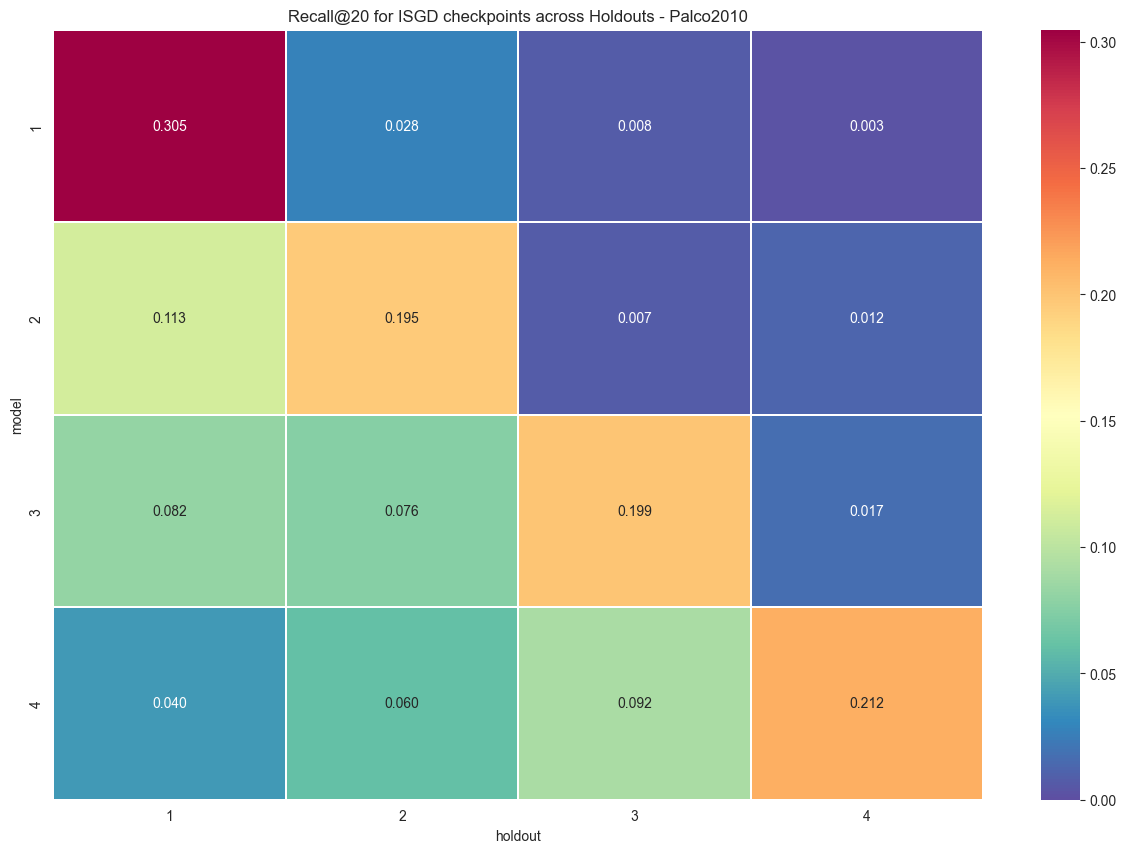

In [24]:
recall_heatmap(df,
    round_point=3,
    title='Recall@20 for ISGD checkpoints across Holdouts - Palco2010',
    filepath='images/heatmaps/palco_2010_dump/sample_palco2010 month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [25]:
arecall = avg_recall(df)
arecall

0.22784185156512032

In [26]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.1917024320457797, -0.17148381616595137, -0.16921065317239728],
 -0.17746563379470945)

In [27]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.012610314212145063

In [28]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/palco_2010_dump/sample_palco2010 month_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/palco_2010_dump/sample_palco2010 month_bucket ISGD eval time.joblib')

['output/palco_2010_dump/sample_palco2010 month_bucket ISGD eval time.joblib']

In [29]:
import pandas as pd
import numpy as np

def avg_recall(results_matrix):
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Díaz-Rodriguez et al. 2018
    diff = []
    n_checkpoints = results_matrix.shape[0]
    for i in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        for j in range(i):
            Rij = results_matrix.iloc[i,j] # get models performances' on previous holdouts
            Rjj = results_matrix.iloc[j,j] # get models performances' on their closest holdouts (diagonal)
            # print(Rij, Rjj)
            diff.append( Rij - Rjj ) # future models performances' - performances' of models closest to holdouts (diagonal)
            # print(diff)
    BWT = sum(diff) / ( n_checkpoints*(n_checkpoints-1) / 2 ) # store average BWT for model
    return BWT, diff # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

In [30]:
df = pd.read_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv')

In [31]:
avg_recall(df).round(3)

0.228

In [32]:
BWT, diff = compute_BWT(df)
print( BWT.round(3) )

-0.174


In [33]:
compute_FWT(df).round(4)

0.0126